# **Predicting Market Prices Using LSTM and Sentiment Analysis**

## **Introduction**

Predicting market prices has always been a challenging yet Closely rewarding endeavor in the financial domain. This project explores this challenge by leveraging the power of **machine learning**—specifically, a **Long Short-Term Memory (LSTM)** network—to forecast market prices. The model integrates **sentiment analysis** as a core feature to capture the psychological and behavioral factors that drive market movements.

---

## **Motivation**
Financial markets are not only influenced by traditional metrics such as supply and demand, earnings reports, and macroeconomic indicators but are also significantly impacted by the **sentiments of investors**. News articles, social media posts, and public sentiment play a critical role in shaping market trends. Traditional time-series models often fail to incorporate this rich layer of information, which is why this project integrates **sentiment analysis** into price prediction.

---

## **Objectives**
The primary objectives of this project are:
1. **Develop a predictive model** leveraging both **historical price data** and **market sentiment** to enhance price forecasting accuracy.
2. Evaluate whether incorporating sentiment analysis provides a competitive edge over traditional models.
3. Explore the **applicability of the model** in actionable trading strategies.

---

## **Methodology**

### **1. Data Collection**
This project combines two key datasets:
- **Market Price Data**: Historical price data, including open, Close, low, close prices, and trading volume.
- **Sentiment Data**: Extracted from financial news articles, social media posts, and other text-based sources. Sentiment scores were derived using **Natural Language Processing (NLP)** techniques.

### **2. Sentiment Analysis**
- **Text Preprocessing**: News headlines and posts were cleaned and tokenized to remove noise.
- **Sentiment Scoring**: Sentiment scores were calculated using pre-trained models like **VADER** or **FinBERT**, fine-tuned for financial text.
- **Feature Engineering**: Aggregated sentiment scores over time windows aligned with price data frequency.

### **3. Model Selection**
- Utilized an **LSTM network**, a form of **Recurrent Neural Network (RNN)**, to capture long-term dependencies in sequential data.
- LSTMs excel at handling the temporal dependencies and non-linearities inherent in market dynamics.

### **4. Model Architecture**
- **Inputs**: Combined **numerical features** (historical prices, trading volume) and **sentiment scores**.
- **Hidden Layers**: LSTM layers captured sequential dependencies, followed by fully connected layers for regression.
- **Output**: Predicted next-day price or directional movement.

### **5. Training and Evaluation**
- Split the dataset into **training**, **validation**, and **test sets**, ensuring no data leakage.
- Optimized using **Mean Squared Error (MSE)** and evaluated with **R² (Coefficient of Determination)**.
- Performed **hyperparameter tuning** to refine learning rates, number of LSTM layers, and units.


# Imports

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import seaborn  as sns
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import OneCycleLR

# Global Methodology

We trained different models using two types of data:
- 1: without including news sentiment analysis
- 2: including news sentiment analysis

---> Maybe a bit dumb: the more you include data, the more your model is precise

---> Strongly depends of the quality of the datasets of the news and the quality of the prediction by the FinBERT model

## Structure of the data used

When we include sentiment data, we add three columns: positive, negative, neutral that describes to three different sentiments for the stock movement.

# Financial Time Series Forecasting using Sentiment Analysis with FinBERT and LSTM

## Loading datasets

In [108]:
%run yahooscraper_index.py

Formatted data successfully saved to data/european_indices.csv


In [109]:
european_indices = pd.read_csv('data/european_indices.csv')
#european_indices = european_indices.dropna()
european_indices = european_indices.sort_values(by= "Date")
#european_indices.dropna(inplace=True)
print(european_indices.shape)
european_indices.head()

(30960, 3)


,Date,Index,Close
0,2017-01-03,FTSEMIB.MI,19573.000000
22704,2017-01-03,^PSI20,4725.410156
8256,2017-01-03,^OBX,627.989990
26832,2017-01-03,^FCHI,4899.330078
4128,2017-01-03,^SSMI,8316.179688


In [61]:
%run BISscraper.py

 11%|█         | 77/716 [01:29<12:21,  1.16s/it]


KeyboardInterrupt: 

In [62]:
%run yahooscraper.py

Fetching S&P 500 data...
Tickers and Companies fetched: 502


Fetching data:  12%|█▏        | 60/502 [00:41<05:06,  1.44it/s]

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to fetch data for BRK.B after 3 retries.


Fetching data:  15%|█▍        | 75/502 [00:55<04:53,  1.45it/s]

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2017-01-01 -> 2024-12-19)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2017-01-01 -> 2024-12-19)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2017-01-01 -> 2024-12-19)')
Failed to fetch data for BF.B after 3 retries.


Fetching data: 100%|██████████| 502/502 [05:50<00:00,  1.43it/s]


Data successfully fetched. Converting to DataFrame...
All data saved to 'data/sp500_prices.csv'


In [6]:
# Load and preprocess `news`
news = pd.read_csv('data/bis_press_releases.csv')
news = news.dropna()
news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
news.sort_values(by='date', ascending=True, inplace=True)
#news = news.set_index('date')

In [7]:
# Group by 'date' and concatenate 'content' values into a single line
news_grouped = news.groupby('date')['content'].apply(lambda x: ' '.join(x)).reset_index()

print(news_grouped.shape)
news_grouped.head()


(1343, 2)


,date,content
0,2017-01-24,"Introductory statement by Mr Benoît Cœuré, Mem..."
1,2017-01-25,"Speech by Mr Mario Draghi, President of the Eu..."
2,2017-01-26,"Speech by Ms Sabine Lautenschläger, Member of ..."
3,2017-01-27,"Speech by Mr Yves Mersch, Member of the Execut..."
4,2017-01-30,"Speech by Dr Veerathai Santiprabhob, Governor ..."


In [8]:
# Load and preprocess `prices`
prices = pd.read_csv('data/sp500_prices.csv')
prices.drop(columns=['Open', 'Low', 'High', 'Volume'], inplace=True)
prices['date'] = pd.to_datetime(prices['Date'])
prices = prices.drop(columns=['Date'])
prices.sort_values(by='date', ascending=True, inplace=True)

In [9]:
#prices = prices.set_index('date')
print(prices.shape)
prices.head()

(980281, 3)


,Close,Company,date
0,148.871231,3M,2017-01-03
325,49.480000,Delta Air Lines,2017-01-03
324,53.669998,Fiserv,2017-01-03
323,165.139999,FactSet,2017-01-03
322,23.475000,Fastenal,2017-01-03


In [21]:
def transform_dataframe_to_wide_format(df, date_column="date", company_column="Company", value_column="Close"):
    """
    Transform the dataframe so that each company becomes a column,
    with values being the close prices and rows indexed by the date.

    :param df: Input DataFrame containing 'date', 'Company', and 'Close' columns.
    :param date_column: Name of the date column.
    :param company_column: Name of the company column.
    :param value_column: Name of the value column (e.g., 'Close').
    :return: Transformed DataFrame with companies as columns and dates as index.
    """
    # Pivot the table to reshape it
    transformed_df = df.pivot_table(index=date_column, columns=company_column, values=value_column)
    
    # Ensure the index is in datetime format and sorted
    #transformed_df.index = pd.to_datetime(transformed_df.index)
    transformed_df = transformed_df.sort_index()
    
    # Return the transformed DataFrame
    return transformed_df

In [22]:
prices_df = transform_dataframe_to_wide_format(prices)
print(prices_df.shape)
prices_df.head()

(2004, 500)


Company,3M,A. O. Smith,AES Corporation,APA Corporation,AT&T,AbbVie,Abbott Laboratories,Accenture,Adobe Inc.,Advanced Micro Devices,...,Williams Companies,Willis Towers Watson,Wynn Resorts,Xcel Energy,Xylem Inc.,Yum! Brands,Zebra Technologies,Zimmer Biomet,Zoetis,eBay
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,148.871231,47.500000,11.66,63.779999,32.492447,62.410000,39.049999,116.459999,103.480003,11.43,...,31.459999,123.239998,87.459999,40.619999,49.650002,63.209999,86.250000,100.320389,53.590000,29.840000
2017-01-04,149.096985,47.919998,11.56,63.590000,32.303623,63.290001,39.360001,116.739998,104.139999,11.43,...,31.360001,124.760002,90.279999,40.799999,50.389999,63.439999,87.029999,101.242722,54.110001,29.760000
2017-01-05,148.586960,47.700001,11.41,63.250000,32.212990,63.770000,39.700001,114.989998,105.910004,11.24,...,31.740000,125.959999,91.440002,40.799999,49.930000,63.650002,84.750000,101.893204,53.930000,30.010000
2017-01-06,149.021744,47.720001,11.82,63.119999,31.208460,63.790001,40.779999,116.300003,108.300003,11.32,...,32.419998,126.779999,92.430000,40.919998,49.580002,64.419998,85.959999,101.902916,54.099998,31.049999
2017-01-09,148.219070,47.400002,11.53,62.360001,30.815710,64.209999,40.740002,115.000000,108.570000,11.49,...,31.930000,126.010002,92.750000,40.299999,49.369999,64.599998,85.970001,103.883492,53.950001,30.750000


In [42]:
for col in prices_df.columns:
    if prices_df[col].isnull().sum() > 0:
        prices_df.drop(columns=[col], inplace=True)

print(prices_df.shape)
prices_df.head()

(2004, 477)


Company,3M,A. O. Smith,AES Corporation,APA Corporation,AT&T,AbbVie,Abbott Laboratories,Accenture,Adobe Inc.,Advanced Micro Devices,...,Williams Companies,Willis Towers Watson,Wynn Resorts,Xcel Energy,Xylem Inc.,Yum! Brands,Zebra Technologies,Zimmer Biomet,Zoetis,eBay
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,148.871231,47.500000,11.66,63.779999,32.492447,62.410000,39.049999,116.459999,103.480003,11.43,...,31.459999,123.239998,87.459999,40.619999,49.650002,63.209999,86.250000,100.320389,53.590000,29.840000
2017-01-04,149.096985,47.919998,11.56,63.590000,32.303623,63.290001,39.360001,116.739998,104.139999,11.43,...,31.360001,124.760002,90.279999,40.799999,50.389999,63.439999,87.029999,101.242722,54.110001,29.760000
2017-01-05,148.586960,47.700001,11.41,63.250000,32.212990,63.770000,39.700001,114.989998,105.910004,11.24,...,31.740000,125.959999,91.440002,40.799999,49.930000,63.650002,84.750000,101.893204,53.930000,30.010000
2017-01-06,149.021744,47.720001,11.82,63.119999,31.208460,63.790001,40.779999,116.300003,108.300003,11.32,...,32.419998,126.779999,92.430000,40.919998,49.580002,64.419998,85.959999,101.902916,54.099998,31.049999
2017-01-09,148.219070,47.400002,11.53,62.360001,30.815710,64.209999,40.740002,115.000000,108.570000,11.49,...,31.930000,126.010002,92.750000,40.299999,49.369999,64.599998,85.970001,103.883492,53.950001,30.750000


## Reduction based on correlation

In [43]:
def remove_highly_correlated_features(df, threshold=0.9):
    """
    Remove highly correlated features based on the correlation matrix, handling potential NaN issues.

    :param df: DataFrame with features as columns.
    :param threshold: Correlation threshold above which features are removed.
    :return: DataFrame with reduced features, excluding highly correlated features.
    """
    # Step 1: Remove any constant columns (to avoid NaNs in correlation matrix)
    df = df.loc[:, (df != df.iloc[0]).any()]  # Keep only non-constant columns

    # Step 2: Compute the correlation matrix
    corr_matrix = df.corr()

    # Step 3: Handle any NaNs in the correlation matrix
    corr_matrix = corr_matrix.fillna(0)

    # Step 4: Identify highly correlated features to drop
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

    # Step 5: Drop highly correlated features
    reduced_df = df.drop(columns=to_drop)
    
    return reduced_df

In [44]:
reduced_df = remove_highly_correlated_features(prices_df, threshold=0.9)
print(reduced_df.shape)
reduced_df.head()

(2004, 181)


Company,3M,A. O. Smith,AES Corporation,APA Corporation,AT&T,AbbVie,Abbott Laboratories,Aflac,Akamai Technologies,Albemarle Corporation,...,United Parcel Service,Universal Health Services,Ventas,Walt Disney Company (The),Warner Bros. Discovery,Wells Fargo,Welltower,Western Digital,Weyerhaeuser,Zimmer Biomet
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,148.871231,47.500000,11.66,63.779999,32.492447,62.410000,39.049999,34.884998,67.570000,88.050003,...,115.080002,106.709999,62.130001,106.080002,27.959999,56.000000,66.169998,69.430000,30.360001,100.320389
2017-01-04,149.096985,47.919998,11.56,63.590000,32.303623,63.290001,39.360001,35.205002,68.330002,90.699997,...,115.110001,108.809998,62.610001,107.440002,28.290001,56.049999,66.680000,70.540001,30.629999,101.242722
2017-01-05,148.586960,47.700001,11.41,63.250000,32.212990,63.770000,39.700001,34.974998,69.550003,90.389999,...,115.169998,108.769997,63.169998,107.379997,27.200001,55.180000,68.169998,70.550003,30.950001,101.893204
2017-01-06,149.021744,47.720001,11.82,63.119999,31.208460,63.790001,40.779999,35.095001,69.790001,90.809998,...,115.400002,108.510002,63.049999,108.980003,27.480000,55.040001,68.449997,70.379997,30.850000,101.902916
2017-01-09,148.219070,47.400002,11.53,62.360001,30.815710,64.209999,40.740002,34.759998,70.000000,90.480003,...,114.769997,111.540001,63.450001,108.360001,26.870001,54.240002,68.400002,71.860001,30.969999,103.883492


## Add the S&P 500 index prices

In [51]:
import yfinance as yf
import datetime

def add_sp500_to_features(wide_format_df, sp500_df):
    """
    Add S&P500 index prices as a feature to the main dataframe.

    :param wide_format_df: DataFrame with existing features (may have multi-level index).
    :param sp500_df: DataFrame with S&P500 index prices.
    :return: Updated DataFrame with S&P500 as a feature.
    """
    # Ensure both DataFrames have a single-level datetime index
    if isinstance(wide_format_df.index, pd.MultiIndex):
        wide_format_df = wide_format_df.reset_index(level=list(range(wide_format_df.index.nlevels - 1)), drop=True)
    if isinstance(sp500_df.index, pd.MultiIndex):
        sp500_df = sp500_df.reset_index(level=list(range(sp500_df.index.nlevels - 1)), drop=True)

    wide_format_df.index = pd.to_datetime(wide_format_df.index)
    sp500_df.index = pd.to_datetime(sp500_df.index)

    # Merge S&P500 index prices into the main dataframe
    combined_df = wide_format_df.merge(sp500_df[['Close']], left_index=True, right_index=True, how='right')

    # Rename the column for clarity
    combined_df.rename(columns={'Close': 'SP500_Close'}, inplace=True)

    # Fill missing S&P500 data (if any)
    combined_df['SP500_Close'] = combined_df['SP500_Close'].fillna(method='ffill').fillna(method='bfill')

    return combined_df

In [56]:
# Step 1: Fetch S&P500 index prices
start_date = reduced_df.index[0]
sp500_df = yf.download('^GSPC', start=start_date, progress=False)

# Step 2: Add S&P500 index prices to your dataset
updated_df = add_sp500_to_features(reduced_df, sp500_df)
print(updated_df.shape)
updated_df.head()

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

## News Data Sentiment Analysis

In [10]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# # Load the tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
# class_labels = model.config.id2label
# prob_labels = model.config.label2id

# text1 = news['content'].values[0]
# inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)

# # Perform inference
# with torch.no_grad():  # No gradient calculation needed for predictions
#     outputs = model(**inputs)
# probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
# predicted_class = torch.argmax(probs, dim=-1).item()

# # Print the results
# print("Predicted class:", class_labels[predicted_class])
# print("Probabilities:", probs)
# print('labels assignation:', prob_labels)

In [11]:
# def sentiment_labelling(df):
#     """
#     Perform sentiment labelling on the given DataFrame.
#     Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
#     Processes the DataFrame to group by date and fill missing values.
#     """
#     # Initialize sentiment columns
#     df['negative'] = 0.0
#     df['neutral'] = 0.0
#     df['positive'] = 0.0

#     # Initialize the tqdm progress bar
#     for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
#         text = row['content']

#         # Tokenize the text
#         inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

#         # Perform inference
#         with torch.no_grad():
#             outputs = model(**inputs)

#         # Get predicted probabilities (softmax output)
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()

#         # Assign probabilities to the corresponding columns
#         df.at[index, 'positive'] = probs[0]
#         df.at[index, 'negative'] = probs[1]
#         df.at[index, 'neutral'] = probs[2]

#     # Drop unnecessary columns
#     if {'url', 'title', 'content'}.issubset(df.columns):
#         df = df.drop(columns=['url', 'title', 'content'])

#     # Group by date and calculate mean sentiment scores
#     df = df.groupby("date").mean().reset_index()

#     # Ensure the 'date' column is in datetime format
#     df['date'] = pd.to_datetime(df['date'])

#     # Create a full date range
#     date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

#     # Reindex to include all dates and forward-fill missing values
#     df = df.set_index("date").reindex(date_range)
#     df = df.ffill().reset_index()
#     df.rename(columns={"index": "date"}, inplace=True)

#     # Sort by date in descending order
#     df = df.sort_values(by="date", ascending=True).reset_index(drop=True)

#     return df

### From skfin

In [1]:
from skfin.datasets import load_fomc_statements, load_loughran_mcdonald_dictionary

In [2]:
statements = load_fomc_statements(from_year=2017)
lm = load_loughran_mcdonald_dictionary()

INFO:skfin.datasets:loading from external source
INFO:skfin.datasets:saving cache file data/fomc_statements.parquet
INFO:skfin.datasets:Loading from external source
INFO:skfin.datasets:File downloaded successfully.


In [3]:
statements['date'] = pd.to_datetime(statements.index)
statements.head()

NameError: name 'pd' is not defined

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from plot import line

def sentiment_labelling(statements, lm, column):
    """
    Perform sentiment labelling on text data using a provided lexicon (lm).
    Returns a DataFrame with sentiment counts, adds 'neutral', normalizes as proportions,
    and drops the 'all' column.

    :param statements: DataFrame containing the text data and date column.
    :param lm: Lexicon (DataFrame) with sentiment-related words.
    :param column: Name of the column in `statements` containing the text data.
    :return: DataFrame with normalized sentiment proportions and the 'date' column.
    """
    # Extract the text column
    X = statements[column]
    
    # Define sentiment functions
    funcs = {
        "negative": lambda x: x.Negative > 0,
        "positive": lambda x: x.Positive > 0,
        "all": lambda x: x.Word.notna(),
    }

    # Helper function to compute total count for a specific sentiment
    def get_total_count(X, lm, func):
        m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
        return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

    # Compute sentiment counts for each sentiment category
    lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

    # Add the neutral feature
    lm_counts["neutral"] = lm_counts["all"] - (lm_counts["positive"] + lm_counts["negative"])

    # Normalize as proportions
    sentiment_columns = ["negative", "positive", "neutral"]
    lm_counts[sentiment_columns] = lm_counts[sentiment_columns].div(lm_counts[sentiment_columns].sum(axis=1), axis=0)

    # Drop the 'all' column
    lm_counts.drop(columns=["all"], inplace=True)

    # Combine the counts with the 'date' column
    if 'date' in statements.columns:
        lm_counts['date'] = statements['date'].values

    # Reset the index to keep a clean DataFrame
    lm_counts.reset_index(drop=True, inplace=True)

    return lm_counts

def fill_missing_dates(df, date_column='date', features=['positive', 'negative', 'neutral']):
    """
    Fill missing dates in a DataFrame and forward-fill the last known values for the given features.

    :param df: DataFrame containing the date column and features.
    :param date_column: Name of the date column in the DataFrame.
    :param features: List of feature column names to forward-fill.
    :return: DataFrame with missing dates filled and values forward-filled.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Create a complete date range
    complete_date_range = pd.date_range(start=df[date_column].min(), end=df[date_column].max(), freq='B')
    
    # Reindex the dataframe to include the complete date range
    df = df.set_index(date_column).reindex(complete_date_range)
    
    # Forward-fill the missing values
    df = df.ffill().reset_index()
    
    # Rename the index column back to the original date column name
    df.rename(columns={'index': date_column}, inplace=True)
    
    return df


In [16]:
sentiment_news = sentiment_labelling(news_grouped, lm, 'content')
sentiment_news = fill_missing_dates(sentiment_news)
sentiment_fomc = sentiment_labelling(statements, lm, 'text')
sentiment_fomc = fill_missing_dates(sentiment_fomc)

In [17]:
print(sentiment_news.shape)
sentiment_news.head()

(2061, 4)


,date,negative,positive,neutral
0,2017-01-24,0.026980,0.020888,0.952132
1,2017-01-25,0.017127,0.019960,0.962913
2,2017-01-26,0.019124,0.019819,0.961057
3,2017-01-27,0.024847,0.009154,0.965998
4,2017-01-30,0.015394,0.017170,0.967436


In [18]:
print(sentiment_fomc.shape)
sentiment_fomc.head()

(2056, 4)


,date,negative,positive,neutral
0,2017-02-01,0.004386,0.015351,0.980263
1,2017-02-02,0.004386,0.015351,0.980263
2,2017-02-03,0.004386,0.015351,0.980263
3,2017-02-06,0.004386,0.015351,0.980263
4,2017-02-07,0.004386,0.015351,0.980263


In [19]:
prices.head()

,Close,Company,date
0,148.871231,3M,2017-01-03
325,49.480000,Delta Air Lines,2017-01-03
324,53.669998,Fiserv,2017-01-03
323,165.139999,FactSet,2017-01-03
322,23.475000,Fastenal,2017-01-03


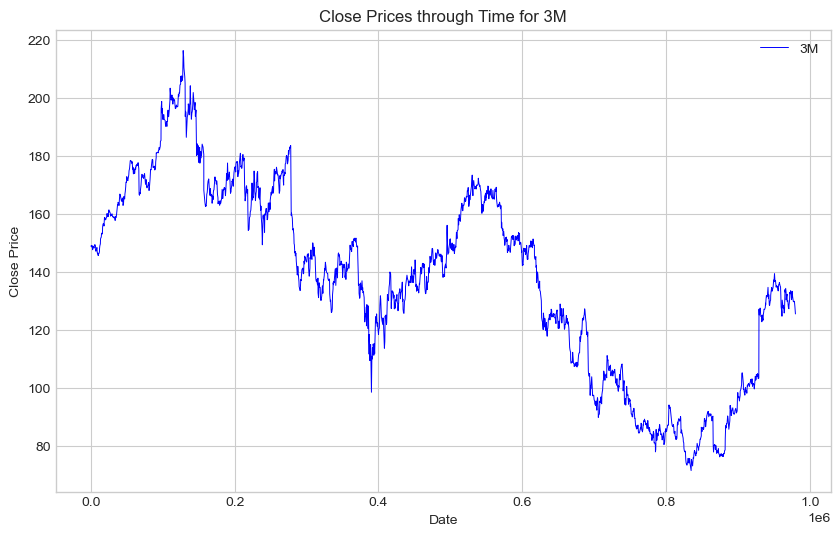

In [20]:
# price = prices[prices['Company'] == '3M']['Close'].values
# dates = prices.index.drop_duplicates().values

# plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
# plt.plot(dates, price, linewidth=0.7, label='3M', c='b')
# plt.legend()
# plt.title('Close Prices through time')
# plt.show()

# Filter data for the specific company
filtered_data = prices[prices['Company'] == '3M']

# Extract Close prices and their corresponding dates
price = filtered_data['Close'].values
dates = filtered_data.index.values  # Use the filtered index

# Plot the data
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
plt.plot(dates, price, linewidth=0.7, label='3M', c='b')
plt.legend()
plt.title('Close Prices through Time for 3M')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


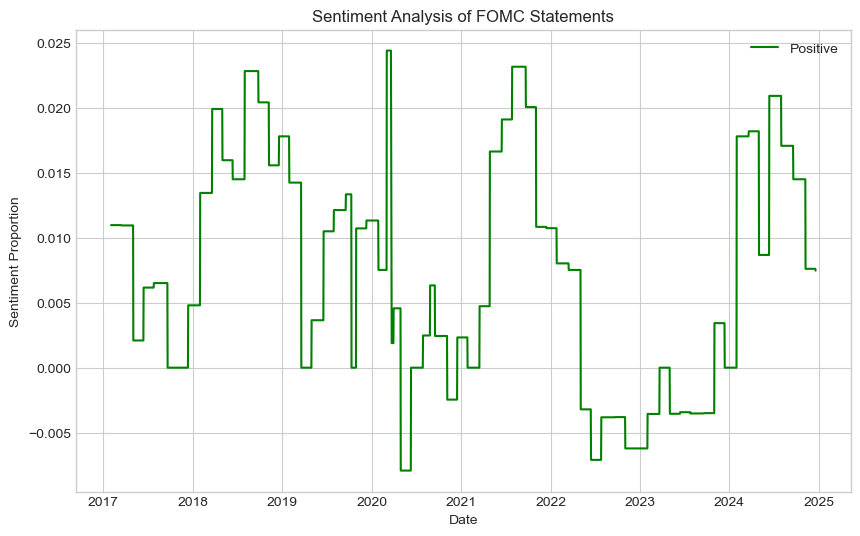

In [490]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
plt.plot(sentiment_fomc['date'], (sentiment_fomc['positive'] - sentiment_fomc['negative'])/(sentiment_fomc['positive'] + sentiment_fomc['negative'] + sentiment_fomc['neutral']), label='Positive', c='g')
plt.legend()
plt.title('Sentiment Analysis of FOMC Statements')
plt.xlabel('Date')
plt.ylabel('Sentiment Proportion')
plt.show()

## Feeding Single Company + sentiment as inputs

In [491]:
def merge_with_sentiments(prices, sentiment_dataframes, date_column='date', fill_features=None):
    """
    Merge the prices DataFrame with a list of sentiment DataFrames, filling missing dates and forward-filling values.

    :param prices: DataFrame containing price data with a date column.
    :param sentiment_dataframes: List of DataFrames containing sentiment data.
    :param date_column: Name of the date column in all DataFrames.
    :param fill_features: List of features in sentiment DataFrames to forward-fill. If None, all features are filled.
    :return: Merged DataFrame with all dates filled and values forward-filled.
    """
    # Ensure the date column in `prices` is in datetime format
    prices[date_column] = pd.to_datetime(prices[date_column])

    # Create a complete date range based on the `prices` DataFrame
    complete_date_range = pd.date_range(start=prices[date_column].min(), end=prices[date_column].max(), freq='B')
    #prices = prices.set_index(date_column).reindex(complete_date_range).reset_index()
    prices.rename(columns={'index': date_column}, inplace=True)

    # Merge each sentiment DataFrame into `prices`
    for sentiment_df in sentiment_dataframes:
        sentiment_df[date_column] = pd.to_datetime(sentiment_df[date_column])

        # Reindex sentiment DataFrame to match the complete date range
        sentiment_df = sentiment_df.set_index(date_column).reindex(complete_date_range)
        
        # Forward-fill missing values for specified features
        if fill_features:
            sentiment_df[fill_features] = sentiment_df[fill_features].ffill()
        else:
            sentiment_df = sentiment_df.ffill()
        
        sentiment_df = sentiment_df.reset_index().rename(columns={'index': date_column})

        # Merge with `prices`
        prices = pd.merge(prices, sentiment_df, on=date_column, how='left')

    # Forward-fill missing values in the final merged DataFrame
    prices = prices.ffill()

    return prices

In [492]:
# List of sentiment DataFrames
sentiments = [sentiment_news, sentiment_fomc]

# Call the function
merged_data = merge_with_sentiments(prices, sentiments)
merged_data = merged_data.dropna()
print(merged_data.shape)
dates = merged_data['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged_data[merged_data['date'] <= split_date]
val = merged_data[merged_data['date'] > split_date]

(972224, 13)


In [493]:
print(train.shape)
train.head()

(774965, 13)


,Open,High,Low,Close,Volume,Company,date,negative_x,positive_x,neutral_x,negative_y,positive_y,neutral_y
9560,99.650002,100.760002,99.000000,100.559998,1643600,PPG Industries,2017-02-01,0.010942,0.01231,0.976747,0.004386,0.015351,0.980263
9561,65.150002,65.970001,63.340000,64.550003,4150200,Qorvo,2017-02-01,0.010942,0.01231,0.976747,0.004386,0.015351,0.980263
9562,26.290001,26.490000,25.969999,26.209999,9607400,Corning Inc.,2017-02-01,0.010942,0.01231,0.976747,0.004386,0.015351,0.980263
9563,174.809998,175.839996,170.059998,170.889999,662200,Domino's,2017-02-01,0.010942,0.01231,0.976747,0.004386,0.015351,0.980263
9564,59.217556,59.417938,58.740459,59.255726,11547702,Merck & Co.,2017-02-01,0.010942,0.01231,0.976747,0.004386,0.015351,0.980263


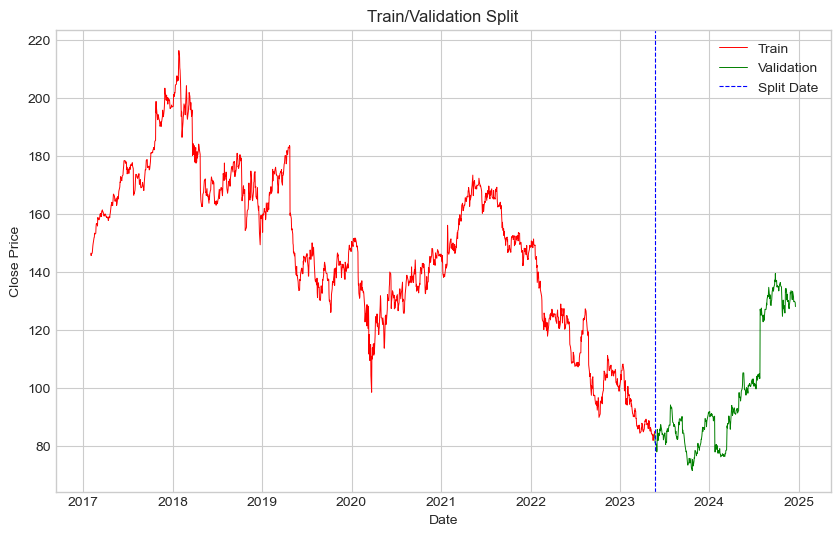

In [494]:
# train_ex = train[train['Company'] == '3M']['Close'].values
# train_dates = train['date'].drop_duplicates().values
# val_ex = val[val['Company'] == '3M']['Close'].values
# val_dates = val['date'].drop_duplicates().values

# plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
# plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
# plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
# plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
# plt.legend()
# plt.title('Train/Validation split')
# plt.show()

# Filter '3M' data for training and validation sets
train_ex = train[train['Company'] == '3M']['Close'].values
train_dates = train[train['Company'] == '3M']['date'].values  # Filter dates for '3M'

val_ex = val[val['Company'] == '3M']['Close'].values
val_dates = val[val['Company'] == '3M']['date'].values  # Filter dates for '3M'

# Ensure the split_date is a datetime object for consistency
split_date = pd.to_datetime(split_date)

# Plot the data
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')

plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
plt.legend()
plt.title('Train/Validation Split')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


## Selecting the features

In [495]:
def sequencing(df, sequence_length):
    data = []
    companies = df['Company'].drop_duplicates().values

    for company in companies[:1]:
        company_data = df[df['Company'] == company][['Close', 'negative_x', 'neutral_x', 'positive_x', 'negative_y', 'neutral_y', 'positive_y']].values
        for i in range(company_data.shape[0]):
            sentiment_values = company_data[i, 1:]
            max_index = np.argmax(sentiment_values)
            binary_sentiment = np.zeros_like(sentiment_values)
            binary_sentiment[max_index] = 1
            # Replace in company_data
            company_data[i, 1:] = binary_sentiment
        data.append(company_data)
    sequenced_data = []
    for d in data:
        if d.shape[0] < sequence_length:
            print(d.shape)
            continue
        for k in range(d.shape[0] - sequence_length):
            sequence = d[k:k + sequence_length, :]
            sequenced_data.append(sequence)
    sequenced_data = np.array(sequenced_data)
    return sequenced_data

train_sequence = sequencing(train, 50)
val_sequence = sequencing(val, 60)

## LSTM Model implementation

In [496]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Features: all columns; Targets: first column (feature 0)
        x = self.data[idx, :-1, :]
        y = self.data[idx, -1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=1e-4, save_path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
                # New best loss found, save the model
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.save_path)
                if self.verbose:
                    print(f"Validation loss improved. Model saved to {self.save_path}")
            else:
                # No improvement, increment counter
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
                    print("Early stopping triggered.")

### Splitting the data

In [497]:
train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Training Loop

In [498]:
import torch
print(torch.backends.mps.is_available())  # Should return True if supported
print(torch.backends.mps.is_built())  # Should also return True

True
True


In [499]:
# Check for MPS availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = train_data.shape[2]
hidden_dim = 256
num_layers = 4
output_dim = 1

learning_rate = 0.01
dropout = 0.2
weight_decay = 1e-4

num_epochs = 256

# Initialize lists to store losses
train_losses = []
test_losses = []

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
early_stopping = EarlyStopping(patience=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        train_loss += loss.item()
    
    # Append average train loss
    train_losses.append(train_loss / len(train_loader))
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Append average test loss
    test_losses.append(test_loss / len(test_loader))
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Using device: mps
Model defined, start training ...
Epoch [1/256], Train Loss: 0.11190725, Test Loss: 0.04432956, LR: 0.000404
Validation loss improved. Model saved to best_model.pth
Epoch [2/256], Train Loss: 0.03755409, Test Loss: 0.03303616, LR: 0.000416
Validation loss improved. Model saved to best_model.pth
Epoch [3/256], Train Loss: 0.02498433, Test Loss: 0.01517110, LR: 0.000436
Validation loss improved. Model saved to best_model.pth
Epoch [4/256], Train Loss: 0.01615017, Test Loss: 0.01250000, LR: 0.000464
Validation loss improved. Model saved to best_model.pth
Epoch [5/256], Train Loss: 0.01036085, Test Loss: 0.00744343, LR: 0.000500
Validation loss improved. Model saved to best_model.pth
Epoch [6/256], Train Loss: 0.00724671, Test Loss: 0.00464584, LR: 0.000544
Validation loss improved. Model saved to best_model.pth
Epoch [7/256], Train Loss: 0.00385707, Test Loss: 0.00235261, LR: 0.000596
Validation loss improved. Model saved to best_model.pth
Epoch [8/256], Train Loss: 0.00

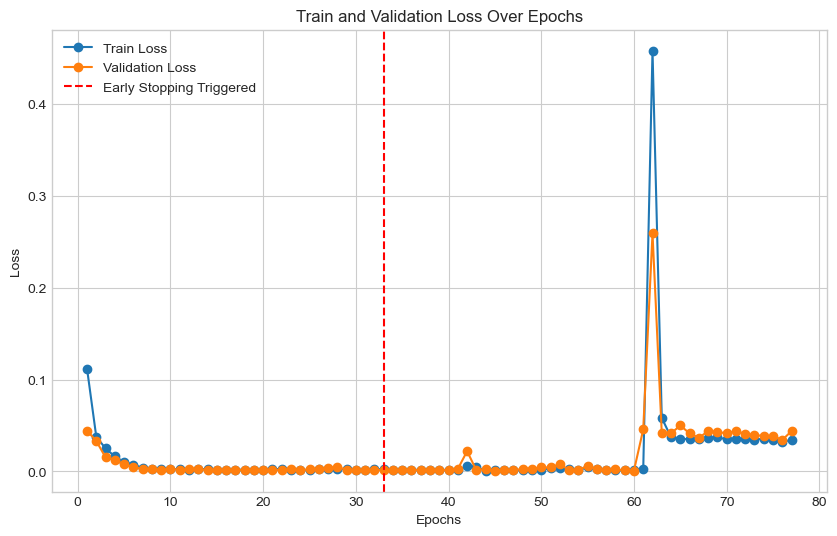

In [505]:
# Plot the train and test losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss', marker='o')
plt.axvline(x=early_stopping.counter + 1, color='r', linestyle='--', label='Early Stopping Triggered')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [506]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [507]:
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    targets = []
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            # Move data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Model inference
            outputs = model(x_batch)
            
            # Detach and move to CPU
            preds = outputs.squeeze().cpu().numpy()  # Shape: (batch_size,)
            true_values = y_batch.cpu().numpy()      # Shape: (batch_size,)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
            # Collect predictions and targets
            predictions.extend(preds)
            targets.extend(true_values)
    print(f"Test Loss: {test_loss/len(test_loader):.8f}")
    # Reshape to 2D arrays (scaler expects 2D inputs)
    predictions = np.array(predictions).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)

    scaler = scalers[0]
    # Apply inverse transform
    predictions = scaler.inverse_transform(predictions)
    targets = scaler.inverse_transform(targets)
    return predictions.flatten(), targets.flatten()

Test Loss: 0.04813730
R² Coefficient on Test Set: 0.9803
Mean Squared Error on Test Set: 9.7682


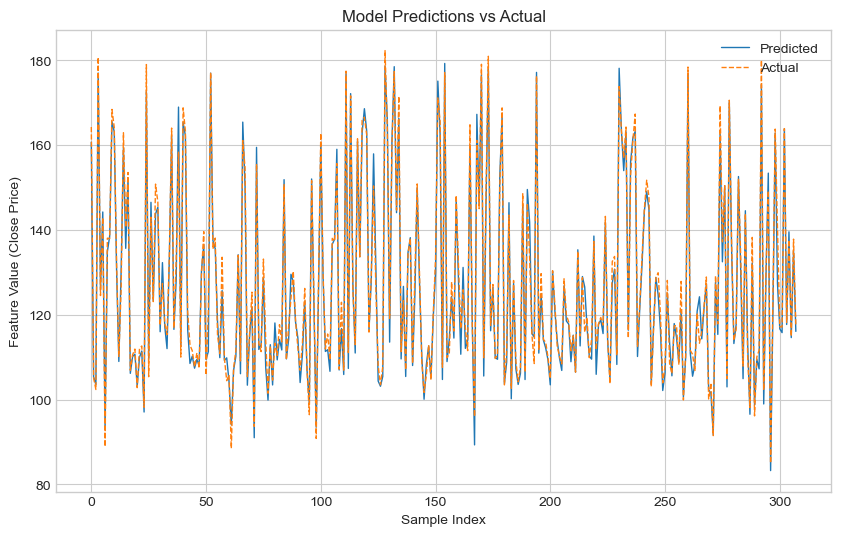

In [508]:
# Evaluate on test set
predictions_test, targets_test = evaluate_model(model, test_loader)
r2 = r2_score(targets_test, predictions_test)
mse = mean_squared_error(targets_test, predictions_test)
print(f"R² Coefficient on Test Set: {r2:.4f}")
print(f"Mean Squared Error on Test Set: {mse:.4f}")

predictions_test_eval, targets_test_eval = predictions_test[:1000], targets_test[:1000]

# Plot Predictions vs Ground Truth
plt.figure(figsize=(10, 6))
plt.plot(predictions_test_eval, label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets_test_eval, label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (Close Price)")
plt.legend()
plt.show()

Test Loss: 0.05776476
R² Coefficient on Validation Set: 0.8759
Mean Squared Error on Validation Set: 107.6685


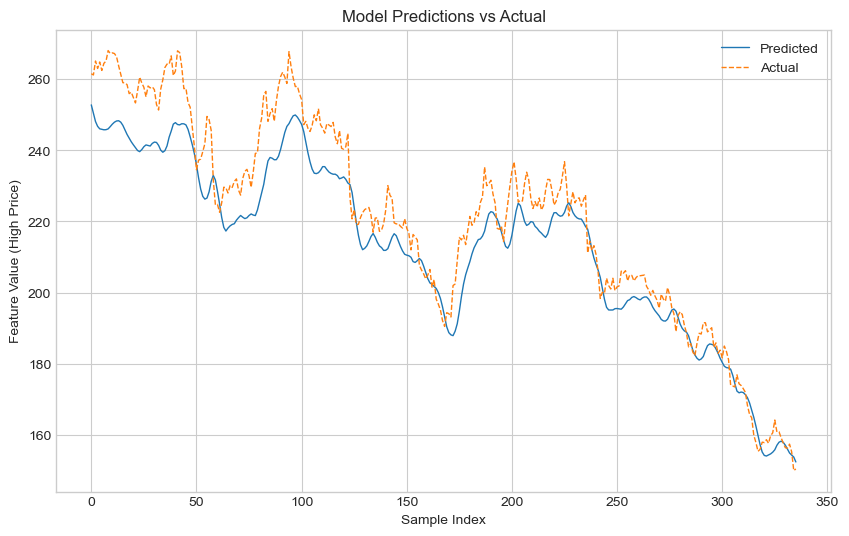

In [509]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

predictions_val, targets_val = evaluate_model(model, val_loader)
#predictions_val = predictions_val + targets_val[0] - predictions_val[0] # Adjust for the first value
r2 = r2_score(targets_val, predictions_val)
mse = mean_squared_error(targets_val, predictions_val)
print(f"R² Coefficient on Validation Set: {r2:.4f}")
print(f"Mean Squared Error on Validation Set: {mse:.4f}")

predictions_val_eval, targets_val_eval = predictions_val[:1000], targets_val[:1000]

# Plot Predictions vs Ground Truth
plt.figure(figsize=(10, 6))
plt.plot(predictions_val_eval, label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets_val_eval, label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/jimmybao/anaconda/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jimmybao/anaconda/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.60E-05


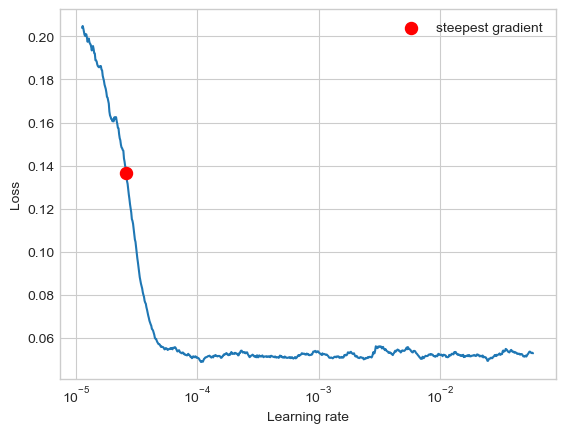

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 2.602647881969006e-05)

In [222]:
from torch_lr_finder import LRFinder

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Start with a small LR
criterion = nn.MSELoss()

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)  # Test LRs between 1e-7 and 1
lr_finder.plot()

# Feeding Companies prices + sentiment as inputs

----> Big Drawback = Dimensionality curse : not enough data and the LSTM doesn't train properly

## Preprocessing data

In [223]:
def dates_filtering(news, prices):
    # Ensure 'date' columns are in datetime format
    news['date'] = pd.to_datetime(news['date'])
    prices['date'] = pd.to_datetime(prices['date'])

    # Find the intersection of dates
    common_dates = set(news['date']).intersection(set(prices['date']))

    # Filter rows from both DataFrames where the date is in the common_dates
    filtered_news = news[news['date'].isin(common_dates)]
    filtered_prices = prices[prices['date'].isin(common_dates)]
    return filtered_news, filtered_prices

In [224]:
news, df = dates_filtering(news, prices)

In [225]:
def mixing_data(news, df, include_news=True, train_size=0.8, random_state=None):
    """
    Combine company data with sentiment data, process features, and split into train-test sets.

    Args:
        news (pd.DataFrame): News sentiment data with 'date', 'negative', 'positive', and 'neutral' columns.
        df (pd.DataFrame): Company stock data with 'Company', 'Close', and 'date' columns.
        include_news (bool): Whether to include sentiment data.
        train_size (float): Proportion of data to use for training.
        random_state (int, optional): Random state for reproducibility.

    Returns:
        tuple: (train_data, test_data), where each is a NumPy array.
    """
    data = []
    companies = df['Company'].drop_duplicates().values
    features = 50  # Number of companies to process
    
    # Process company data
    for company in tqdm(companies[:features], desc="Processing company data"):
        company_data = df[df['Company'] == company]['Close'].values
        data.append(company_data)

    data = np.array(data)  # Shape: (features, timesteps)
    
    # Include sentiment data if specified
    if include_news:
        sentiment_data = []
        dates = df['date'].drop_duplicates().values

        for date in tqdm(dates[1:], desc="Processing sentiment data"):
            sentiment_data_day = news[news['date'] == date][['negative', 'positive', 'neutral']].values.flatten()
            sentiment_data.append(sentiment_data_day)

        sentiment_data = np.array(sentiment_data)  # Shape: (timesteps, sentiment_features)

        # Check for timestep mismatch
        if data.shape[1] != sentiment_data.shape[0]:
            raise ValueError(f"Mismatch in timesteps: company_data ({data.shape[1]}) vs sentiment_data ({sentiment_data.shape[0]})")

        sentiment_data = sentiment_data.T  # Shape: (sentiment_features, timesteps)
        
        # Combine company data with sentiment data
        data = np.concatenate((data, sentiment_data), axis=0).T  # Shape: (timesteps, features + sentiment_features)

    # Train-test split
    train_data, test_data = train_test_split(
        data,
        train_size=train_size,
        shuffle=False,  # Maintain temporal order
        random_state=random_state
    )

    return train_data, test_data

In [226]:
train_data, test_data = mixing_data(news, df, include_news=True)

Processing sentiment data: 100%|██████████| 1336/1336 [00:01<00:00, 936.56it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1336,) + inhomogeneous part.

In [78]:
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, target_indices, sequence_length):
        self.data = data # Shape must be : (data_length, num_features)
        self.target_indices = target_indices
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.sequence_length, :]
        y = self.data[idx+self.sequence_length, self.target_indices]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [96]:
def load_multivariate_data(train_data, test_data, target_index, sequence_length):
    # Scale each feature independently
    # MinMaxScaling produces constant outputs because there are too small values
    scalers = [StandardScaler() for _ in range(train_data.shape[1])]
    train_scaled = np.zeros_like(train_data)
    test_scaled = np.zeros_like(test_data)
    for i, scaler in enumerate(scalers):
        train_scaled[:, i] = scaler.fit_transform(train_data[:, i].reshape(-1, 1)).flatten()
        test_scaled[:, i] = scaler.transform(test_data[:, i].reshape(-1, 1)).flatten()
    train_dataset = MultivariateTimeSeriesDataset(train_scaled, target_index, sequence_length)
    test_dataset = MultivariateTimeSeriesDataset(test_scaled, target_index, sequence_length)
    
    return train_dataset, test_dataset, scalers

In [97]:
sequence_length = 30
target_indices = [k for k in range(50)]

train_dataset, test_dataset, scalers = load_multivariate_data(train_data, test_data, target_indices, sequence_length)

In [ ]:
print("Train data shape", train_dataset.data.shape)
print("Validation data shape", test_dataset.data.shape)

In [99]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model

### LSTM

In [100]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, intermediate_size=256, dropout=0.2):
        super(LSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(intermediate_size, intermediate_size)
        self.tanh = nn.Tanh()
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(intermediate_size, output_size)
    
    def forward(self, x, h0=None, c0=None):
        # Use hidden states only if provided
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer to produce the final output
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout2(out)
        out = self.fc3(out) # Shape: (batch_size, output_size)
        return out

### Early Stopping

In [101]:
class EarlyStopping:
    """Early stopping to terminate training when validation loss stops improving."""
    def __init__(self, patience=5, delta=0, verbose=False, path="checkpoint.pth"):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
            path (str): Path to save the best model checkpoint.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")  # Initialize minimum validation loss

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Model Definition

In [ ]:
input_size = train_data.shape[1]
output_size = len(target_indices)

# Hyperparameters for the structure of the model
hidden_size = 64
num_layers = 3
dropout = 0.0

# Training hyperparameters
learning_rate = 0.01
epochs = 1000

# Initialize the LSTM model
lstm = LSTM(input_size, hidden_size, output_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=100, verbose=True)

## Training Loop

In [103]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, early_stopping=None, clip_value=1.0):
    """
    Train the model with detailed logging for loss variations and learning rate changes.

    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer.
        scheduler: Learning rate scheduler.
        epochs: Number of training epochs.
        early_stopping: EarlyStopping object for patience-based stopping.
        clip_value: Gradient clipping value.
    """
    prev_val_loss = None  # Track previous validation loss
    prev_lr = optimizer.param_groups[0]['lr']  # Track previous learning rate
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                y_pred = model(batch_x)
                loss = criterion(y_pred, batch_y)
                val_loss += loss.item() * batch_x.size(0)

        val_loss /= len(val_loader.dataset)

        # Log the losses
        loss_change = f"({val_loss - prev_val_loss:.6f})" if prev_val_loss is not None else ""
        print(f"\nEpoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f} {loss_change}")
        prev_val_loss = val_loss

        # Scheduler step and learning rate logging
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        if current_lr < prev_lr:  # Log only if LR was updated
            print(f"Learning Rate decreased ({prev_lr:.6e} --> {current_lr:.6e}).")
        prev_lr = current_lr  # Update previous learning rate

        # Early stopping (if provided)
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"\nEarly stopping triggered. Final validation loss: {val_loss:.6f}")
                break

In [ ]:
train_model(
    model=lstm, 
    train_loader=train_loader, 
    val_loader=test_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=epochs, 
    early_stopping=early_stopping,
    scheduler=scheduler
    )

## Evaluation

In [86]:
def get_prediction():
    lstm.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = lstm(batch_x)
            y_true.append(batch_y.numpy())
            y_pred.append(outputs.numpy())
    # Concatenate all batches
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Inverse transform predictions and ground truth for the target features
    y_true_rescaled, y_pred_rescaled = [], []
    for i, target_index in enumerate(target_indices):
        scaler = scalers[target_index]
        y_true_rescaled.append(scaler.inverse_transform(y_true[:, i].reshape(-1, 1)).flatten())
        y_pred_rescaled.append(scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten())

    y_true_rescaled = np.stack(y_true_rescaled, axis=1)
    y_pred_rescaled = np.stack(y_pred_rescaled, axis=1)
    return y_true_rescaled, y_pred_rescaled

In [87]:
def evaluate_model(model, test_loader, scalers, target_indices):
    y_true_rescaled, y_pred_rescaled = get_prediction()
    # Compute R2 scores for each feature
    r2_scores = [r2_score(y_true_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(len(target_indices))]
    return r2_scores

In [ ]:
r2_scores = evaluate_model(
    model=lstm,
    test_loader=test_loader,
    scalers=scalers,
    target_indices=target_indices
)

print(f'Average r2 score: {np.mean(r2_scores)}')

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
plt.bar(range(len(r2_scores)), r2_scores, width=0.5)
plt.xlabel("Index", fontsize=12)
plt.ylabel("R2 Score", fontsize=12)
plt.title("Bar Plot of R2 Scores", fontsize=14)
plt.show()

In [303]:
def plot_predictions(num_samples=10):
    y_true, y_pred = get_prediction()
    for i in range(50, 50 + num_samples):
        # Compute R2 score
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        # Plot true and predicted values
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[:, i], label='True', linewidth=0.5)
        plt.plot(y_pred[:, i], label='Predicted', linewidth=0.8)
        
        # Add R2 score to the legend
        plt.title(f"Asset {i}")
        plt.legend([f"True", f"Predicted (r2: {r2:.3f})"])
        plt.show()


In [ ]:
plot_predictions()

# Application with trading strategies ?